In [2]:
from __future__ import annotations

import numpy as np
import pandas as pd

from typing import *

In [3]:
from nepal.datasets import NYTimes
from nepal.ml.preprocess import Cases

df: pd.DataFrame = Cases(NYTimes()).preprocessed()

In [5]:
from typing import Callable, NamedTuple

from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    MeanAbsoluteError,
)


class Loss(NamedTuple):
    name: str
    function: Callable


mae = Loss(
    name="mean_absolute_error",
    function=MeanAbsoluteError(),
)

mape = Loss(
    name="mean_absolute_percentage_error",
    function=MeanAbsolutePercentageError(symmetric=True),
)

In [6]:
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.splitter import Splitter
from nepal.ml.validate import cross_validate

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(objective=mae.name), lag=12)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df[["new_cases"]], loss=mae.function
)
print(np.mean(scores))

Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

30.965630324684287


<AxesSubplot:>

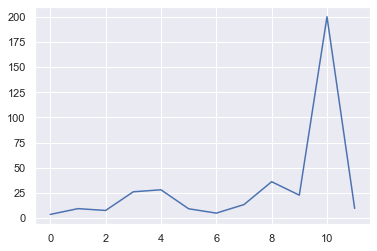

In [7]:
import seaborn as sns

sns.set(style="darkgrid")
sns.lineplot(data=scores)

In [ ]:
import optuna

from sklearn.pipeline import Pipeline
from nepal.ml.transformers import RollingWindowSum

transformers: Pipeline = Pipeline(
    [
        (
            "with_active_infections",
            RollingWindowSum("new_cases", target="infections", window=10),
        ),
    ]
)


def objective(trial: optuna.Trial) -> float:
    lag = trial.suggest_int("lag", 10, 12)
    forecaster = LGBMForecaster(
        lgb.LGBMRegressor(objective=mae.name), lag=lag, transformers=transformers
    )

    scores: Sequence[float] = cross_validate(
        forecaster, splitter=splitter, y=df[["new_cases"]], loss=mae.function
    )
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)

study.best_params
# Best found lag value with default LGBM params: 13

In [10]:
from nepal.graph import Connection, LocalConnection, GraphDB

conn: Connection = LocalConnection(
    database="neo4j",
    password="corona",
)

assert conn.is_up()

In [13]:
import optuna
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.splitter import Splitter

from nepal.graph.gds import CountyEmbedding


embedding = CountyEmbedding()
embedding.create_projection(conn)

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)


def objective(trial: optuna.Trial) -> float:
    forecaster = LGBMForecaster(lgb.LGBMRegressor(objective=mae.name), lag=12)

    X: pd.DataFrame = embedding.load_dataframe(
        connection=conn,
        embedding_dimension=trial.suggest_int("dim", 8, 512, log=True),
        weight2=trial.suggest_float("weight2", 0.0, 1.0),
        weight3=trial.suggest_float("weight3", 0.0, 1.0),
        weight4=trial.suggest_float("weight4", 0.0, 1.0),
        normalization=trial.suggest_float("normalization", -1.0, 1.0),
        property_ratio=trial.suggest_float("prop_ratio", 0.0, 1.0),
        self_influence=trial.suggest_float("self_influence", 0.0, 1.0),
    ).rename(index={"fips": "FIPS"})

    scores: Sequence[float] = cross_validate(
        forecaster, splitter=splitter, y=df[["new_cases"]], Xs=[X], loss=mae.function
    )
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

study.best_params
# Best found values with default LGBM params and lag=12:
# {'dim': 13,
#  'weight2': 0.9095431576049532,
#  'weight3': 0.3804723961743889,
#  'weight4': 0.9975167117131349,
#  'normalization': -0.9871365897384008,
#  'prop_ratio': 0.12685783148389826,
#  'self_influence': 0.44962816623765073}

[I 2022-06-01 20:56:17,049] A new study created in memory with name: no-name-63d4f69f-9fbd-4201-8b03-182df9a8d6ac


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 20:57:48,015] Trial 0 finished with value: 30.847329788952635 and parameters: {'dim': 23, 'weight2': 0.9463261683719523, 'weight3': 0.07854714192529177, 'weight4': 0.30181327763992216, 'normalization': 0.7824211591882893, 'prop_ratio': 0.48473742618136995, 'self_influence': 0.1107871319701621}. Best is trial 0 with value: 30.847329788952635.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 20:59:21,606] Trial 1 finished with value: 30.978690457780086 and parameters: {'dim': 25, 'weight2': 0.5254398393660553, 'weight3': 0.9719153317611482, 'weight4': 0.2848871340076513, 'normalization': -0.8738295100419884, 'prop_ratio': 0.6466804617875547, 'self_influence': 0.7248647323475229}. Best is trial 0 with value: 30.847329788952635.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:00:49,718] Trial 2 finished with value: 30.85818269310562 and parameters: {'dim': 17, 'weight2': 0.7377244943435936, 'weight3': 0.9200735089364865, 'weight4': 0.5546745134300508, 'normalization': 0.7790156721908101, 'prop_ratio': 0.48983968186252236, 'self_influence': 0.28440736717504034}. Best is trial 0 with value: 30.847329788952635.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:02:21,850] Trial 3 finished with value: 30.833856122974694 and parameters: {'dim': 8, 'weight2': 0.08694122302121399, 'weight3': 0.405948437292195, 'weight4': 0.37829549295615683, 'normalization': 0.7161793576858579, 'prop_ratio': 0.7471283801543478, 'self_influence': 0.5180359086471884}. Best is trial 3 with value: 30.833856122974694.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:05:55,313] Trial 4 finished with value: 30.914397072195914 and parameters: {'dim': 212, 'weight2': 0.35887284414821485, 'weight3': 0.6646061076172014, 'weight4': 0.8916139231602844, 'normalization': 0.5777076057246642, 'prop_ratio': 0.26902634739773557, 'self_influence': 0.4589609661084526}. Best is trial 3 with value: 30.833856122974694.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:07:10,187] Trial 5 finished with value: 30.844648184427665 and parameters: {'dim': 10, 'weight2': 0.19106867700044694, 'weight3': 0.7761673674714425, 'weight4': 0.7935762750597714, 'normalization': 0.9796067386901623, 'prop_ratio': 0.4484057566984555, 'self_influence': 0.7659140383805088}. Best is trial 3 with value: 30.833856122974694.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:09:04,251] Trial 6 finished with value: 31.197967484491574 and parameters: {'dim': 104, 'weight2': 0.36481706072472786, 'weight3': 0.6372430887745522, 'weight4': 0.8129546722917946, 'normalization': -0.601349451450391, 'prop_ratio': 0.5762504284893583, 'self_influence': 0.16260136062170516}. Best is trial 3 with value: 30.833856122974694.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:12:53,142] Trial 7 finished with value: 31.048979421683796 and parameters: {'dim': 273, 'weight2': 0.39628758043796386, 'weight3': 0.5514876896873007, 'weight4': 0.9092674843099909, 'normalization': -0.3106799204756472, 'prop_ratio': 0.05408878507881787, 'self_influence': 0.6319157734964296}. Best is trial 3 with value: 30.833856122974694.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:14:47,005] Trial 8 finished with value: 30.930058164904533 and parameters: {'dim': 95, 'weight2': 0.6043042387016521, 'weight3': 0.08573225453499167, 'weight4': 0.42753782217079306, 'normalization': -0.9992716716724124, 'prop_ratio': 0.5190438454720084, 'self_influence': 0.5364805253877545}. Best is trial 3 with value: 30.833856122974694.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:16:03,271] Trial 9 finished with value: 30.926795367550785 and parameters: {'dim': 15, 'weight2': 0.41352375863111934, 'weight3': 0.733337216707431, 'weight4': 0.12960229085490493, 'normalization': -0.40821278656356275, 'prop_ratio': 0.43077858558399007, 'self_influence': 0.5365616512069137}. Best is trial 3 with value: 30.833856122974694.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:17:31,615] Trial 10 finished with value: 30.8077243303904 and parameters: {'dim': 42, 'weight2': 0.013004209825647858, 'weight3': 0.33110505995404493, 'weight4': 0.6225157605575766, 'normalization': 0.17384310410478088, 'prop_ratio': 0.925436889393256, 'self_influence': 0.8545044793092034}. Best is trial 10 with value: 30.8077243303904.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:19:07,562] Trial 11 finished with value: 31.034930534401955 and parameters: {'dim': 49, 'weight2': 0.024825489203726188, 'weight3': 0.3326668513977894, 'weight4': 0.6238752589555212, 'normalization': 0.2531376561188521, 'prop_ratio': 0.9742411258081226, 'self_influence': 0.9971982991609823}. Best is trial 10 with value: 30.8077243303904.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:20:25,408] Trial 12 finished with value: 30.896981808214935 and parameters: {'dim': 8, 'weight2': 0.0009075395449358453, 'weight3': 0.32065685840502167, 'weight4': 0.6303788171041775, 'normalization': 0.27900958562739925, 'prop_ratio': 0.9163975843683556, 'self_influence': 0.9729071779630851}. Best is trial 10 with value: 30.8077243303904.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:21:51,868] Trial 13 finished with value: 31.045455002474238 and parameters: {'dim': 42, 'weight2': 0.1417050764911461, 'weight3': 0.3455896456496639, 'weight4': 0.03497188156794079, 'normalization': 0.06619101799625447, 'prop_ratio': 0.7439895553900221, 'self_influence': 0.8324366238776912}. Best is trial 10 with value: 30.8077243303904.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:23:47,149] Trial 14 finished with value: 30.80219460867086 and parameters: {'dim': 109, 'weight2': 0.1648515719416457, 'weight3': 0.22426708055854813, 'weight4': 0.4044864562751409, 'normalization': 0.5106964037278878, 'prop_ratio': 0.7676442123544605, 'self_influence': 0.3855633123021922}. Best is trial 14 with value: 30.80219460867086.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:25:47,803] Trial 15 finished with value: 30.85860179664687 and parameters: {'dim': 110, 'weight2': 0.21080890472885253, 'weight3': 0.18528876783561934, 'weight4': 0.7203051444730385, 'normalization': 0.3649914094438834, 'prop_ratio': 0.8319761718805088, 'self_influence': 0.43913432311588463}. Best is trial 14 with value: 30.80219460867086.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:32:16,473] Trial 16 finished with value: 30.955770001964428 and parameters: {'dim': 416, 'weight2': 0.23482184967014957, 'weight3': 0.17701769590786934, 'weight4': 0.48601333886405795, 'normalization': -0.18443439216948332, 'prop_ratio': 0.8543170314585332, 'self_influence': 0.36786401127368584}. Best is trial 14 with value: 30.80219460867086.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:34:16,782] Trial 17 finished with value: 30.98072330547596 and parameters: {'dim': 70, 'weight2': 0.2890925334564929, 'weight3': 0.4597298575035551, 'weight4': 0.21982226239192998, 'normalization': -0.016997439584544166, 'prop_ratio': 0.6994390472478296, 'self_influence': 0.0074378721799480685}. Best is trial 14 with value: 30.80219460867086.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:37:05,386] Trial 18 finished with value: 30.80182532612682 and parameters: {'dim': 171, 'weight2': 0.1098466804080176, 'weight3': 0.23137727890329607, 'weight4': 0.9990393397476212, 'normalization': 0.477181295517087, 'prop_ratio': 0.9621922841319558, 'self_influence': 0.8641665730171354}. Best is trial 18 with value: 30.80182532612682.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-01 21:39:40,962] Trial 19 finished with value: 30.814017189866277 and parameters: {'dim': 139, 'weight2': 0.6985277390179263, 'weight3': 0.009578592772053085, 'weight4': 0.3731235514947818, 'normalization': 0.44416683562118947, 'prop_ratio': 0.8254202066849298, 'self_influence': 0.30220541999824824}. Best is trial 18 with value: 30.80182532612682.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
# Evaluate found parameters

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=13)
embedding = CountyEmbedding()

X: pd.DataFrame = embedding.load_dataframe(
    connection=conn,
    embedding_dimension=16,
    weight2=0.9,
    weight3=0.4,
    weight4=1.0,
    normalization=-1.0,
    property_ratio=0.15,
    self_influence=0.45,
)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df[["new_cases"]], Xs=[X]
)

print(np.mean(scores))

Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

1.1615128487786013
